In [104]:
import torch, random
import torch.optim as optim
import torch.nn as nn
import numpy as np
from matplotlib import pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
def positional_encoding(x: torch.Tensor, dim: int = 64):
    """Apply fourier positional encoding to the input.

    Args:
      x (torch.Tensor): a 1 dimension tensor of indices
      dim (optional, int): dimension of positional encoding. max index representable is 2^(dim//2+1). Default: 64.
    Returns:
      (torch.Tensor): Positional encoding of the input tensor. dimension: [x.size(0), dim]
    """
    position = x.unsqueeze(1)
    device = x.device  # Get the device of x

    # Create div_term on the same device as x
    div_term = torch.exp(
        torch.arange(0, dim, 2, dtype=torch.float32, device=device) *\
            (-np.log(10000.0) / dim)
    )

    # Create pe on the same device as x
    pe = torch.zeros(x.size(0), dim, device=device)

    # Perform computations
    pe[:, 0::2] = torch.sin(position * div_term)
    pe[:, 1::2] = torch.cos(position * div_term)
    return pe

def positional_encoding(x:torch.tensor, dim:int=64):
    """Apply fourier positional encoding to the input.

    Args:
      x (torch.Tensor): a 1 dimension tensor of indices
      dim (optional, int): dimension of positional encoding. max index representable is 2^(dim//2+1). Default: 64.
    Returns:
      (torch.Tensor): Positional encoding of the input tensor. dimension: [x.size(0), dim]
    """
    results = []
    # encode input tensor and append the encoded tensor to the list of results.
    for i in range(dim//2):
        freq = 2 ** (i+1) #add 2 bc freq<4 is uninformative
        x_mod_freq = x % freq
        for func in [torch.sin, torch.cos]:
            result = func(2 * torch.pi * x_mod_freq / freq)
            results.append(result)
    return torch.stack(results, dim=-1)

def positional_encoding(x: torch.Tensor, dim: int = 48):
    """
    Binary positional encoding, where each dimension is a bit in the binary representation of the index.
    
    Args:
        x (torch.Tensor): Input tensor of positions with shape [N]
        dim (int): Number of bits in the binary encoding (output dimension). Default is 48.

    Returns:
        torch.Tensor: A binary encoding tensor with shape [N, dim] where each bit represents a binary position.
    """
    # Ensure x is an integer tensor for binary conversion
    x = x.to(torch.int64)

    # Create a tensor for binary representation
    # Each row corresponds to an element in x; columns are the binary bits
    encoding = ((x.unsqueeze(1) >> torch.arange(dim, device=x.device)) & 1).to(torch.float32)
    
    # Flip the encoding to match the conventional binary order (most significant bit on the left)
    encoding = encoding.flip(dims=[1])

    return encoding

In [3]:
class AUNNModel(nn.Module):
    def __init__(self, embedding_dim, output_dim, num_layers, hidden_dim):
        super(AUNNModel, self).__init__()
        assert embedding_dim % 2 == 0, "Embedding dimension must be even."
        assert num_layers % 2 == 0 and num_layers >= 2, "Number of layers must be even and at least 2."

        self.embedding_dim = embedding_dim
        self.output_dim = output_dim
        self.num_layers = num_layers
        self.hidden_dim = hidden_dim

        # Input Layer
        self.input_layer = nn.Sequential(
            nn.Linear(self.embedding_dim, self.hidden_dim),
            nn.SiLU(),
            nn.RMSNorm(self.hidden_dim)
        )

        # Hidden Layers
        self.layers = nn.ModuleList()
        for _ in range(self.num_layers - 2):  # Exclude input and output layers
            self.layers.append(nn.Sequential(
                nn.Linear(self.hidden_dim, self.hidden_dim),
                nn.SiLU(),
                nn.RMSNorm(self.hidden_dim)
            ))

        # Output Layer
        self.output_layer = nn.Linear(self.hidden_dim, self.output_dim)

        # Initialize weights
        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                # He initialization for Swish activation
                nn.init.kaiming_normal_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, x):
        output = self.input_layer(x)
        residual = output  # Initialize residual for skip connections

        for idx, layer in enumerate(self.layers):
            output = layer(output)

            # Apply skip connection every two layers
            if (idx + 1) % 2 == 0:
                output = output + residual  # Skip connection
                residual = output  # Update residual

        output = self.output_layer(output)
        return output

In [ ]:
from torch.utils.data import Dataset, DataLoader

# Dataset Class
class TextDataset(Dataset):
    def __init__(self, text, embed_dim):

        # Tokenize the text into characters
        tokens = list(text)

        # Create a vocabulary and mappings
        vocab = sorted(set(tokens))
        self.vocab_size = len(vocab)
        self.token_to_id = {token: id for id, token in enumerate(vocab)}
        self.id_to_token = {id: token for token, id in self.token_to_id.items()}

        # Convert tokens to indices
        self.token_ids = [self.token_to_id[token] for token in tokens]

        # Assign indices to each position in the text
        self.positions = torch.arange(len(self.token_ids), dtype=torch.float32)

        self.embed_dim = embed_dim
        self.inputs = positional_encoding(self.positions, self.embed_dim)
        self.targets = torch.tensor(self.token_ids, dtype=torch.long)
        
    def __len__(self):
        return len(self.positions)
    
    def __getitem__(self, idx):
        return self.inputs[idx], self.targets[idx]
    
class DynamicTextDataset(Dataset):
    def __init__(self, num_sequences:int, pattern:str, embedding_dim:int):

        self.pattern = pattern
        vocab = sorted(set(list(pattern)))
        self.vocab_size = len(vocab)
        self.token_to_id = {token: id for id, token in enumerate(vocab)}
        self.id_to_token = {id: token for token, id in self.token_to_id.items()}

        self.embedding_dim = embedding_dim
        self.total_chars = num_sequences * len(pattern) # Total number of characters

    def __len__(self):
        return self.total_chars

    def __getitem__(self, idx):
        # Determine which sequence and position within the sequence this idx corresponds to
        position_in_sequence = idx % len(self.pattern)

        # Get the token at the specific position
        token = self.pattern[position_in_sequence]
        token_id = self.token_to_id[token]

        # Create the position tensor
        position = torch.tensor([idx], dtype=torch.float32)

        # Apply positional encoding
        input_tensor = positional_encoding(position, self.embedding_dim).squeeze(0)

        # Convert to tensor
        target_tensor = torch.tensor(token_id, dtype=torch.long)

        return input_tensor, target_tensor

class RandomTextDataset(Dataset):
    def __init__(self, num_sequences, options, embedding_dim):

        assert len(set(len(x) for x in options)) == 1, "all sequences must have same length"

        self.options = options
        vocab = sorted(set(list(''.join(options))))
        self.vocab_size = len(vocab)
        self.token_to_id = {token: id for id, token in enumerate(vocab)}
        self.id_to_token = {id: token for token, id in self.token_to_id.items()}

        self.embedding_dim = embedding_dim
        self.sequence_length = len(options[0])
        self.total_chars = num_sequences * self.sequence_length # Total number of characters

    def __len__(self):
        return self.total_chars

    def __getitem__(self, idx):
        # Determine which sequence and position within the sequence this idx corresponds to
        sequence_idx = idx // self.sequence_length
        position_in_sequence = idx % self.sequence_length

        # Generate the sequence, use sequence_idx as the seed
        rng = random.Random(sequence_idx)
        sequence_choice = rng.choice(self.options)
        sequence_tokens = list(sequence_choice)

        # Get the token at the specific position
        token = sequence_tokens[position_in_sequence]
        token_id = self.token_to_id[token]

        # Create the position tensor
        position = torch.tensor([idx], dtype=torch.float32)

        # Apply positional encoding
        input_tensor = positional_encoding(position, self.embedding_dim).squeeze(0)

        # Convert to tensor
        target_tensor = torch.tensor(token_id, dtype=torch.long)

        return input_tensor, target_tensor

In [37]:
# Hyperparameters
embedd_dim = 64
num_layers = 8     # Must be even and at least 2 (bc of skip connections)
hidden_dim = 512   # Size of hidden layers
batch_size = 2048  # Adjust batch size for efficiency
num_epochs = 500

In [ ]:
#really long repeated pattern
'''
text = "abc" * 10_000  # Repeat the sequence to create a long string
dataset = TextDataset(text, embedd_dim)
dataloader = DataLoader(dataset, batch_size=batch_size)
'''

#really long repeated pattern, but generated dynamically to avoid memory issues
'''
pattern = "abc"
num_sequences = 1_000_000
dataset = DynamicTextDataset(num_sequences, pattern, embedd_dim)
dataloader = DataLoader(dataset, batch_size=batch_size)
'''

#randomly generated string with local structure but no global structure
options = ['|aaa','|bbb','|ccc']
num_sequences = 100_000
dataset = RandomTextDataset(num_sequences, options, embedd_dim)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [ ]:
# Initialize the model, loss function, and optimizer
model = AUNNModel(embedd_dim, dataset.vocab_size, num_layers, hidden_dim).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters())

# Training Loop
losses = []
total_steps = len(dataloader)
for epoch in range(num_epochs):
    epoch_losses = []
    total_loss = 0
    model.train()
    for batch_idx, (inputs, targets) in enumerate(dataloader):

        inputs = inputs.to(device)
        targets = targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * inputs.size(0)

        # Print within-epoch progress
        if (batch_idx + 1) % 10 == 0 or (batch_idx + 1) == total_steps:
            avg_loss = total_loss / ((batch_idx + 1) * batch_size)
            epoch_losses.append(avg_loss)
            progress = (batch_idx + 1) / total_steps * 100
            print(f"Epoch [{epoch+1}/{num_epochs}], Step [{batch_idx+1}/{total_steps}], "
                  f"Progress: {progress:.2f}%, Loss: {avg_loss:.6f}")

    avg_loss = total_loss / len(dataset)
    losses.append(epoch_losses)
    print(f"Epoch [{epoch+1}/{num_epochs}] completed, Average Loss: {avg_loss:.6f}")

Epoch [1/500], Step [10/196], Progress: 5.10%, Loss: 4.370742
Epoch [1/500], Step [20/196], Progress: 10.20%, Loss: 2.783973
Epoch [1/500], Step [30/196], Progress: 15.31%, Loss: 2.170452
Epoch [1/500], Step [40/196], Progress: 20.41%, Loss: 1.845085
Epoch [1/500], Step [50/196], Progress: 25.51%, Loss: 1.646151
Epoch [1/500], Step [60/196], Progress: 30.61%, Loss: 1.512069
Epoch [1/500], Step [70/196], Progress: 35.71%, Loss: 1.415349
Epoch [1/500], Step [80/196], Progress: 40.82%, Loss: 1.342560
Epoch [1/500], Step [90/196], Progress: 45.92%, Loss: 1.286105
Epoch [1/500], Step [100/196], Progress: 51.02%, Loss: 1.240261
Epoch [1/500], Step [110/196], Progress: 56.12%, Loss: 1.202415
Epoch [1/500], Step [120/196], Progress: 61.22%, Loss: 1.171750
Epoch [1/500], Step [130/196], Progress: 66.33%, Loss: 1.145878
Epoch [1/500], Step [140/196], Progress: 71.43%, Loss: 1.123456
Epoch [1/500], Step [150/196], Progress: 76.53%, Loss: 1.103517
Epoch [1/500], Step [160/196], Progress: 81.63%, L

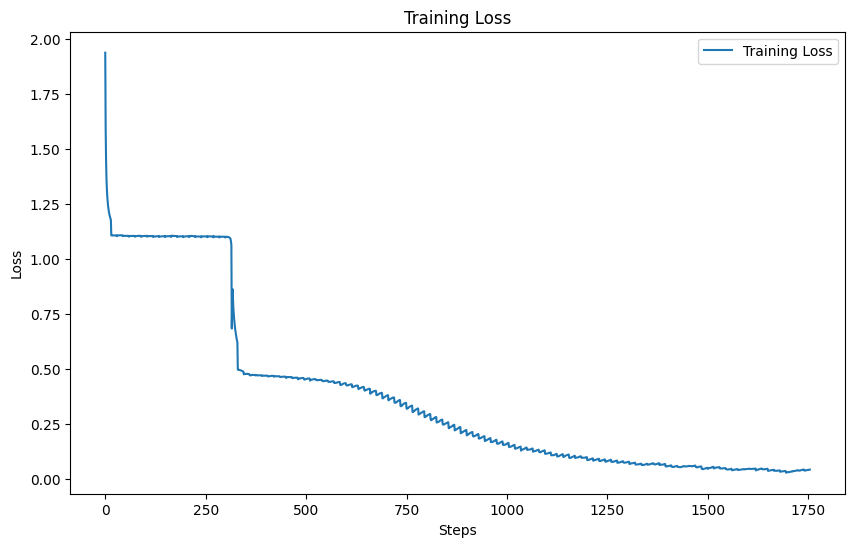

In [ ]:
all_losses = []
for epoch_loss in losses:
    all_losses.extend(epoch_loss)

# Plot the loss curves
plt.figure(figsize=(10, 6))
plt.plot(all_losses, label="Training Loss")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.legend()
plt.show()

In [72]:
# Generate Text Function
def generate_text(model, start_index, length):
    model.eval()
    generated_tokens = []
    indices = np.arange(start_index, start_index + length)
    x = torch.tensor(indices, dtype=torch.float32).to(device)
    inputs = positional_encoding(x, embedd_dim).to(device)
    with torch.no_grad():
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
    for id in predicted:
        token = dataset.id_to_token.get(id.item(), "<UNK>")
        generated_tokens.append(token)
    return ''.join(generated_tokens)

# Generate text starting from the next index after the training data
start_index = 0
generated_text = generate_text(model, start_index=start_index, length=50)
print("Generated Text:")
print(generated_text)

# Generate text starting from the next index after the training data
start_index = len(dataset)
generated_text = generate_text(model, start_index=start_index, length=50)
print("Generated Text:")
print(generated_text) #learns underlying pattern & generalizes to unseen indices :)

Generated Text:
|bbb|aaa|aaa|aaa|aaa|ccc|ccc|bbb|aaa|bbb|ccc|bbb|b
Generated Text:
|aaa|aaa|aaa|aaa|ccc|bbb|aaa|bbb|ccc|aaa|aaa|aaa|a


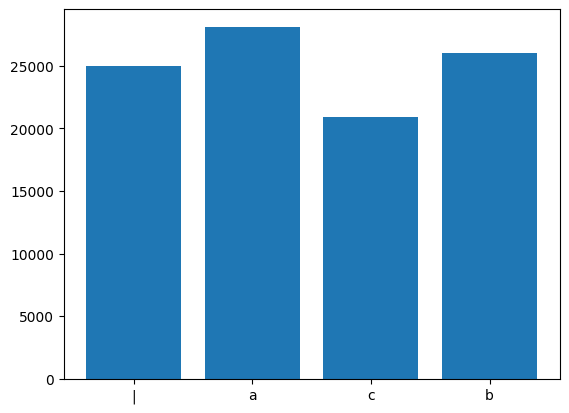

In [105]:
N = len(dataset) - 1
preds = generate_text(model, start_index=N+1, length=100_000)
count = {}
for char in preds:
    count[char] = count.get(char, 0) + 1

plt.bar(count.keys(), count.values())
plt.show()

In [73]:
# Evaluate the accuracy of the model on the dataset via random sample of 10k characters
import random

# Number of samples
num_samples = 10_000

# Randomly select indices from the dataset
sample_indices = random.sample(range(len(dataset)), num_samples)

# Get positions and targets for the sampled indices
inputs = []
outputs = []
for idx in sample_indices:
    input, output = dataset[idx]
    inputs.append(input)
    outputs.append(output)

# Concatenate the inputs and outputs
inputs = torch.stack(inputs).to(device)
outputs = torch.stack(outputs).to(device)

# Get model predictions
model.eval()
with torch.no_grad():
    predictions = model(inputs)
    _, predicted = torch.max(predictions, 1)
    
# Calculate accuracy
correct = (predicted == outputs).sum().item()
accuracy = correct / num_samples
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 100.00%


In [ ]:
# Define a function to save the model checkpoint
def save_checkpoint(model, optimizer, epoch, loss, filename="checkpoint.pth"):
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
    }
    torch.save(checkpoint, filename)
    print(f"Checkpoint saved at epoch {epoch} with loss {loss:.4f}")

save_checkpoint(model, optimizer, epoch+1, avg_loss, filename=f"checkpoint_epoch_{epoch+1}.pth")

Checkpoint saved at epoch 500 with loss 0.0000


In [109]:
def load_checkpoint(model, optimizer, filename="checkpoint.pth"):
    checkpoint = torch.load(filename, weights_only=True)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']
    print(f"Checkpoint loaded: epoch {epoch}, loss {loss:.4f}")
    return epoch, loss

model = AUNNModel(embedd_dim, dataset.vocab_size, num_layers, hidden_dim).to(device)
optimizer = optim.AdamW(model.parameters())
start_epoch, start_loss = load_checkpoint(model, optimizer, filename="checkpoint_epoch_500.pth")

Checkpoint loaded: epoch 500, loss 0.0000


In [110]:
#experiment with conditioning via backprop

N = len(dataset) - 1

generated_text = generate_text(model, start_index=N+1, length=100)
print("Original Text:")
print(generated_text) # "|a..."
print("")

# 2. Conditioning the model
conditioning_positions = [N + 1, N + 2]
conditioning_targets = ['|', 'c']  # Desired tokens at N+1 and N+2, this also works if you use "|b"
conditioning_target_indices = [dataset.token_to_id[token] for token in conditioning_targets]

positions_tensor = torch.tensor(conditioning_positions, dtype=torch.float32).to(device)
targets_tensor = torch.tensor(conditioning_target_indices, dtype=torch.long).to(device)
inputs = positional_encoding(positions_tensor, embedd_dim).to(device)

criterion = nn.CrossEntropyLoss()
conditioning_optimizer = optim.SGD(model.parameters(), lr=1e-3)
model.train()
num_conditioning_steps = 1

for step in range(num_conditioning_steps):
    conditioning_optimizer.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, targets_tensor)
    loss.backward()
    conditioning_optimizer.step()
    print(f"Conditioning Step {step+1}/{num_conditioning_steps}, Loss: {loss.item():.6f}")
    print("")

generated_text = generate_text(model, start_index=N+1, length=100)
print("Text after conditioning:")
print(generated_text) # "|bbb|..." shows conditioning works because of N+3 and N+4

Original Text:
|aaa|aaa|aaa|aaa|ccc|bbb|aaa|bbb|ccc|aaa|aaa|aaa|aaa|bbb|aaa|bbb|aaa|bbb|aaa|bbb|bbb|bbb|ccc|bbb|ccc

Conditioning Step 1/1, Loss: 0.724056

Text after conditioning:
|ccc|ccc|ccc|bbb|ccc|bbb|ccc|bbb|ccc|aaa|aaa|aaa|ccc|bbb|ccc|bbb|ccc|ccc|aaa|bbb|bbb|bbb|ccc|bbb|ccc
